In [20]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---

## VEST's Documentation File

Election results from Wyoming Secretary of State (https://soswy.state.wy.us/Elections/ElectionResults.aspx)
Precinct shapefile primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release. The Fremont County shapefile was provided by the Fremont County Assessor.
 
The following modifications were made to recreate the 2018 precinct boundaries.

Albany: Consolidate 8 county VTDs into 5 precincts, 18 city VTDs into 8 precincts \ 
Campbell: Align 1-27/24-1 with Gillette municipal boundary \
Carbon: Remove district splits for 1-2, 5-1, 6-1, 7-1, 11-2, 12-1, 13-1 \
Goshen: Align VTDs with legislative districts and 2012 redistricting map \
Laramie: Adjust 03-06, 03-07 to reverse Cheyenne annexations \
Platte: Merge Y-O Ranch into Wheatland Rural \
Sheridan: Remove district splits for 01-01, 02-01, 02-03, 03-03, 11-03 \
Sweetwater: Align wards and precincts countywide with 2012 legislative redistricting \
Uinta: Remove 02-01 district split; Split 01-03/01-04; Merge 04-01/04-03 \
Weston: Adjust 5-2/5-3 boundary to match 2012 realignment

G18USSRBAR - John Barrasso (Republican Party) \
G18USSDTRA - Gary Trauner (Democratic Party) \
G18USSLPOR - Joseph Porambo (Libertarian Party) \
G18USSOWRI - Write-in Votes

G18HALRCHE - Liz Cheney (Republican Party) \
G18HALDHUN - Greg Hunter (Democratic Party) \
G18HALLBRU - Richard Brubaker (Libertarian Party) \
G18HALCCUM - Daniel Clyde Cummings (Constitution Party) \
G18HALOWRI - Write-in Votes

G18GOVRGOR - Mark Gordon (Republican Party) \
G18GOVDTHR - Mary A. Throne (Democratic Party) \
G18GOVLSTR - Lawrence Gerard Struempf (Libertarian Party) \
G18GOVCRAM - Rex "T-Rex" Rammell (Constitution Party) \
G18GOVOWRI - Write-in Votes

G18SOSRBUC - Edward Buchanan (Republican Party) \
G18SOSDBYR - James W. Byrd (Democratic Party) \
G18SOSLCAR - Kit Carson III (Libertarian Party) \
G18SOSOWRI - Write-in Votes

G18AUDRRAC - Kristi Racines (Republican Party) \
G18AUDDDOC - Jeff Dockter (Democratic Party) \
G18AUDOWRI - Write-in Votes

G18TRERMEI - Curt Meier (Republican Party) \
G18TREDLOW - Chris Lowry (Democratic Party) \
G18TREOWRI - Write-in Votes

G18SPIRBAL - Jillian Balow (Republican Party) \
G18SPIOWRI - Write-in Votes

### Load VEST's Final File

In [21]:
vest_shp = gp.read_file("./raw_from_source/VEST/wy_2018/wy_2018.shp")

In [22]:
vest_shp.shape

(483, 31)

In [23]:
vest_shp.head()

,STATEFP20,COUNTYFP20,VTDST20,NAME20,G18USSRBAR,G18USSDTRA,G18USSLPOR,G18USSOWRI,G18HALRCHE,G18HALDHUN,...,G18SOSOWRI,G18AUDRRAC,G18AUDDDOC,G18AUDOWRI,G18TRERMEI,G18TREDLOW,G18TREOWRI,G18SPIRBAL,G18SPIOWRI,geometry
0,56,045,000101,NEWCASTLE RURAL OUTSIDE,428,64,15,2,398,73,...,0,439,63,0,447,60,0,462,4,"MULTIPOLYGON (((-104.22316 43.85669, -104.2231..."
1,56,045,000102,Northwest,327,48,13,0,311,51,...,0,332,44,0,323,54,0,335,6,"POLYGON ((-104.55704 43.85906, -104.55691 43.8..."
2,56,045,000301,UPTON OUTSIDE,201,13,5,0,195,13,...,0,197,13,0,194,17,0,194,1,"POLYGON ((-105.08141 43.82696, -105.08139 43.8..."
3,56,045,000201,OSAGE,118,10,9,0,108,8,...,0,119,13,0,119,14,0,121,2,"POLYGON ((-104.59766 43.85787, -104.59762 43.8..."
4,56,045,000501,NEWCASTLE EAST,292,51,15,1,259,68,...,0,304,45,0,295,51,0,310,4,"POLYGON ((-104.20615 43.85409, -104.20606 43.8..."


<AxesSubplot:>

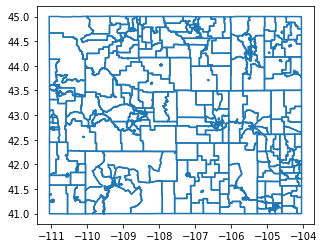

In [24]:
vest_shp.boundary.plot()

In [25]:
vest_shp.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G18USSRBAR',
       'G18USSDTRA', 'G18USSLPOR', 'G18USSOWRI', 'G18HALRCHE', 'G18HALDHUN',
       'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI', 'G18GOVRGOR', 'G18GOVDTHR',
       'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI', 'G18SOSRBUC', 'G18SOSDBYR',
       'G18SOSLCAR', 'G18SOSOWRI', 'G18AUDRRAC', 'G18AUDDDOC', 'G18AUDOWRI',
       'G18TRERMEI', 'G18TREDLOW', 'G18TREOWRI', 'G18SPIRBAL', 'G18SPIOWRI',
       'geometry'],
      dtype='object')

# Election Results

## Load Files

The SOS directed to this link for election results for the 2018 general: https://soswy.state.wy.us/Elections/ElectionResults.aspx


In [26]:
#Grab the folder 
loaded_counties = os.listdir("./raw_from_source/VEST/2018_WY_Election_Results/")

#Create a list to add the county data too
li = []
#Iterate over all the counties
for file in loaded_counties:
    #Just work on the county file
    if "County_General_PbP" in file: 
        #Create the file path
        file_string = "./raw_from_source/VEST/2018_WY_Election_Results/" + file
        #Import the file
        df = pd.read_excel(file_string, 'Sheet1', index_col = [0], header = [0,1]) 
        #Filter down columns (first level of multi-index)
        df = df[['United States Senator','United States Representative','Governor','Secretary of State','State Auditor','State Treasurer','Superintendent of Public Instruction']]
        #Rename the columns to deal with the multi-index
        df.columns=['_'.join(col) if type(col) is tuple else col for col in df.columns.values]
        #Filter down columns
        df = df[['United States Senator_John\nBarrasso (R)',
       'United States Senator_Gary\nTrauner (D)',
       'United States Senator_Joseph\nPorambo (L)',
       'United States Senator_Write-Ins', 
       'United States Representative_Liz\nCheney (R)',
       'United States Representative_Greg\nHunter (D)',
       'United States Representative_Richard\nBrubaker (L)',
       'United States Representative_Daniel Clyde\nCummings (C) ',
       'United States Representative_Write-Ins',
       'Governor_Mark\nGordon (R)',
       'Governor_Mary A.\nThrone (D)',
       'Governor_Lawrence Gerard\nStruempf (L)',
       'Governor_Rex "T-Rex"\nRammell (C)', 'Governor_Write-Ins',
       'Secretary of State_Edward\nBuchanan (R)',
       'Secretary of State_James W.\nByrd (D)',
       'Secretary of State_Kit\nCarson III (L)',
       'Secretary of State_Write-Ins', 'State Auditor_Kristi\nRacines (R)',
       'State Auditor_Jeff\nDockter (D)', 'State Auditor_Write-Ins',
       'State Treasurer_Curt\nMeier (R)', 'State Treasurer_Chris\nLowry (D)',
       'State Treasurer_Write-Ins',
       'Superintendent of Public Instruction_Jillian\nBalow (R)',
       'Superintendent of Public Instruction_Write-Ins']]
        #Add the county
        df["County"] = file[5:len(file)-24]
        #Add the data to the list
        li.append(df)
        print("Working on "+ file)
#Create the final dataframe
final_results = pd.concat(li)

Working on 2018_Teton_County_General_PbP.xlsx
Working on 2018_Fremont_County_General_PbP.xlsx
Working on 2018_Converse_County_General_PbP.xlsx
Working on 2018_Uinta_County_General_PbP.xlsx
Working on 2018_Albany_County_General_PbP.xlsx
Working on 2018_Lincoln_County_General_PbP.xlsx
Working on 2018_Campbell_County_General_PbP.xlsx
Working on 2018_Goshen_County_General_PbP.xlsx
Working on 2018_Johnson_County_General_PbP.xlsx
Working on 2018_Platte_County_General_PbP.xlsx
Working on 2018_Weston_County_General_PbP.xlsx
Working on 2018_Sublette_County_General_PbP.xlsx
Working on 2018_Carbon_County_General_PbP.xlsx
Working on 2018_Niobrara_County_General_PbP.xlsx
Working on 2018_Laramie_County_General_PbP.xlsx
Working on 2018_Natrona_County_General_PbP.xlsx
Working on 2018_Sheridan_County_General_PbP.xlsx
Working on 2018_Crook_County_General_PbP.xlsx
Working on 2018_Sweetwater_County_General_PbP.xlsx
Working on 2018_Hot_Springs_County_General_PbP.xlsx
Working on 2018_Big_Horn_County_General

### Clean Up the Election Results

In [27]:
#Deal with the index
final_results.reset_index(drop=False,inplace=True)

#Rename the columns to match VEST
final_results.columns = ["Precinct",'G18USSRBAR','G18USSDTRA','G18USSLPOR','G18USSOWRI',
       'G18HALRCHE', 'G18HALDHUN', 'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI',
       'G18GOVRGOR', 'G18GOVDTHR', 'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI',
       'G18SOSRBUC','G18SOSDBYR','G18SOSLCAR','G18SOSOWRI','G18AUDRRAC','G18AUDDDOC','G18AUDOWRI',
       'G18TRERMEI','G18TREDLOW','G18TREOWRI','G18SPIRBAL','G18SPIOWRI','County']

#Remove the rows with Total votes
final_results = final_results[final_results["Precinct"]!="Total"]

#Fill n/a values with 0
final_results = final_results.fillna(0)

### Check Statewide Candidate Totals

In [28]:
data_columns = ['G18USSRBAR','G18USSDTRA','G18USSLPOR','G18USSOWRI',
       'G18HALRCHE', 'G18HALDHUN', 'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI',
       'G18GOVRGOR', 'G18GOVDTHR', 'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI',
       'G18SOSRBUC','G18SOSDBYR','G18SOSLCAR','G18SOSOWRI','G18AUDRRAC','G18AUDDDOC','G18AUDOWRI',
       'G18TRERMEI','G18TREDLOW','G18TREOWRI','G18SPIRBAL','G18SPIOWRI']

print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])- final_results[race].sum() != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-final_results[race].sum())+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(final_results[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(vest_shp[race])), "\tRDH: " + str(final_results[race].sum()))
print("")
print("All other races are equal")

Printing differences below
G18USSRBAR is equal 	VEST: 136210 	RDH: 136210.0
G18USSDTRA is equal 	VEST: 61227 	RDH: 61227.0
G18USSLPOR is equal 	VEST: 5658 	RDH: 5658.0
G18USSOWRI is equal 	VEST: 325 	RDH: 325.0
G18HALRCHE is equal 	VEST: 127963 	RDH: 127963.0
G18HALDHUN is equal 	VEST: 59903 	RDH: 59903.0
G18HALLBRU is equal 	VEST: 6918 	RDH: 6918.0
G18HALCCUM is equal 	VEST: 6070 	RDH: 6070.0
G18HALOWRI is equal 	VEST: 391 	RDH: 391.0
G18GOVRGOR is equal 	VEST: 136412 	RDH: 136412.0
G18GOVDTHR is equal 	VEST: 55965 	RDH: 55965.0
G18GOVLSTR is equal 	VEST: 3010 	RDH: 3010.0
G18GOVCRAM is equal 	VEST: 6751 	RDH: 6751.0
G18GOVOWRI is equal 	VEST: 1100 	RDH: 1100.0
G18SOSRBUC is equal 	VEST: 137026 	RDH: 137026.0
G18SOSDBYR is equal 	VEST: 53355 	RDH: 53355.0
G18SOSLCAR is equal 	VEST: 8561 	RDH: 8561.0
G18SOSOWRI is equal 	VEST: 156 	RDH: 156.0
G18AUDRRAC is equal 	VEST: 143980 	RDH: 143980.0
G18AUDDDOC is equal 	VEST: 52461 	RDH: 52461.0
G18AUDOWRI is equal 	VEST: 222 	RDH: 222.0
G18TRE

### Check County Totals

#### Add in County FIPs data

In [29]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw_from_source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Wyoming"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

#Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"Big_Horn":"Big Horn",'Hot_Springs':"Hot Springs"}
final_results["County"] = final_results["County"].map(county_name_changes_dict).fillna(final_results["County"])

#Use the dictionary to go from a county name to a county FIPS
final_results["County"] = final_results["County"].map(fips_dict).fillna(final_results["County"])

#Check the number of counties - looking for 23
print(len(final_results["County"].unique()))

23


#### Check the Results

In [30]:
print("Counties with differences printed below:")
diff_counties=[]
for i in data_columns:
    diff = vest_shp.groupby(['COUNTYFP20']).sum()[i]-final_results.groupby(["County"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


### Check Precinct Votes

#### Create a 'join_col' in Both Files

In [12]:
#Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP20"]+"-"+vest_shp["NAME20"]+vest_shp["VTDST20"]
#Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

#Create an election results join col
final_results["join_col"] = final_results["County"]+"-"+final_results["Precinct"]
#Check to make sure it is unique
print(final_results["join_col"].value_counts(dropna=False))

027-SOUTH LUSK000602                                1
033-FAIRGROUNDS EXHIBIT HALL (SAGEBRUSH 2)002-03    1
021-3-80003-8                                       1
005-01-25001-25                                     1
005-14-01014-01                                     1
                                                   ..
029-CODY WEST INSIDE002503                          1
023-DIAMONDVILLE NO. 4000104                        1
033-RANCHESTER TOWN HALL (OUTSIDE)017-02            1
011-PINE HAVEN001515                                1
021-1-30001-3                                       1
Name: join_col, Length: 483, dtype: int64
015-Hawk Springs Community Center 17-1      1
037-Wamsutter Town Hall 23-1                1
021-Laramie County Community College 7-4    1
031-Wheatland Rural, 4-H Building 1-6       1
025-Poison Spider School 11-4               1
                                           ..
015-Torrington Rendezvous Center 10-4       1
021-VFW Post #1881 3-10                   

#### First Join Attempt
Note: Not expecting any to join because we added VTDST20 to the VEST ID. 
(added b/c that will be helpful to justify the name changes)

In [13]:
join_attempt_one = pd.merge(vest_shp,final_results,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

join_attempt_one[join_attempt_one["_merge"]=="left_only"].to_csv("./only_vest.csv")
join_attempt_one[join_attempt_one["_merge"]=="right_only"].to_csv("./only_elections.csv")

#### Change Names to Perform Join

In [14]:
election_vest_id_changes_dict = {'001-National Guard Armory 14-1': '001-National Guard Armory 14-1001401', '001-Albany County Fairgrounds 46-11': '001-Albany County Fairgrounds 46-11004611', '001-Linford Elementary School 45-1': '001-Linford Elementary School 45-1004501', '001-Shields Street. Aux. Gym (Old H.S.) 13-1': '001-Shields Street. Aux. Gym 13-1001301', '001-New Laramie High School 46-2': '001-New Laramie High School 46-2004602', '001-Lincoln Community Center 45-2': '001-Lincoln Community Center 45-2004502', '001-Spring Creek Elementary School 13-3': '001-Spring Creek Elementary School 13-3001303', '001-Laramie Peak Fire Hall 14-11': '001-Laramie Peak Fire Hall 14-11001411', '001-New Laramie High School 46-1': '001-New Laramie High School 46-1004601', '001-Harmony School 46-12': '001-Harmony School 46-12004612', '001-Centennial School 46-13': '001-Centennial School 46-13004613', '001-Rock River Town Hall 47-11': '001-Rock River Town Hall 47-11004711', '001-Shields Street. Aux. Gym (Old H.S.) 13-2': '001-Shields Street. Aux. Gym 13-2001302', '003-Lovell-Community Center 20-1': '003-Lovell002001', '003-Greybull-Elks Lodge 11-1': '003-Greybull001101', '003-Basin-Fair Grounds 1-1': '003-Basin000101', '003-Cowley-Log Gym 22-1': '003-Cowley002201', '003-Burlington-Fire Hall 2-1': '003-Burlington000201', '003-Byron-Town Complex 23-1': '003-Byron002301', '003-Shell-Community Hall 16-1': '003-Shell001601', '003-Manderson-Town Hall 8-1': '003-Manderson000801', '003-Frannie-Community Center 26-1': '003-Frannie002601', '003-Otto-Burlington Fire Hall 3-1': '003-Otto000301', '003-Hayattville-Community Center 6-1': '003-Hyattville000601', '003-Deaver-Community Hall 25-1': '003-Deaver002501', '003-Emblem-Greybull Irrigation District Office 5-1': '003-Emblem000501', '005-Cam-Plex Wyoming Center 1-15': '005-01-15001-15', '005-Cam-Plex Wyoming Center 3-1': '005-03-01003-01', '005-Rozet School 4-1': '005-04-01004-01', '005-Cam-Plex Wyoming Center 1-16': '005-01-16001-16', '005-Cam-Plex Wyoming Center 1-23': '005-01-23001-23', '005-Cam-Plex Wyoming Center 1-7': '005-01-07001-07', '005-Cam-Plex Wyoming Center 1-19': '005-01-19001-19', '005-Cam-Plex Wyoming Center 23-1': '005-23-01023-01', '005-Cam-Plex Wyoming Center 1-25': '005-01-25001-25', '005-Cam-Plex Wyoming Center 1-27': '005-01-27001-27', '005-Cam-Plex Wyoming Center 1-9': '005-01-09001-09', '005-Cam-Plex Wyoming Center 1-5': '005-01-05001-05', '005-Cam-Plex Wyoming Center 1-12': '005-01-12001-12', '005-Wright Town Hall 14-1': '005-14-01014-01', '005-Cam-Plex Wyoming Center 1-17': '005-01-17001-17', '005-Cam-Plex Wyoming Center 1-18': '005-01-18001-18', '005-Cam-Plex Wyoming Center 18-1': '005-18-01018-01', '005-Cam-Plex Wyoming Center 24-1': '005-24-01024-01', '005-Wright Town Hall 14-2': '005-14-02014-02', '005-Cam-Plex Wyoming Center 1-24': '005-01-24001-24', '005-Cam-Plex Wyoming Center 2-1': '005-02-01002-01', '005-Cam-Plex Wyoming Center 1-1': '005-01-01001-01', '005-Cam-Plex Wyoming Center 1-26': '005-01-26001-26', '005-Cam-Plex Wyoming Center 1-3': '005-01-03001-03', '005-Cam-Plex Wyoming Center 19-1': '005-19-01019-01', '005-Cam-Plex Wyoming Center 1-22': '005-01-22001-22', '005-Cam-Plex Wyoming Center 1-21': '005-01-21001-21', '005-Cam-Plex Wyoming Center 1-11': '005-01-11001-11', '005-Rawhide School 6-1': '005-06-01006-01', '005-4-J School 13-1': '005-13-01013-01', '005-Cam-Plex Wyoming Center 1-14': '005-01-14001-14', '005-Cam-Plex Wyoming Center 1-20': '005-01-20001-20', '005-Cam-Plex Wyoming Center 22-1': '005-22-01022-01', '005-Recluse Community Hall 7-1': '005-07-01007-01', '005-Little Powder School 8-1': '005-08-01008-01', '005-Cam-Plex Wyoming Center 9-1': '005-09-01009-01', '005-Cam-Plex Wyoming Center 26-1': '005-26-01026-01', '007-Platte Valley Community Center 11-1': '007-SARATOGA 11-10011-1', '007-Jeffrey Center 3-2': '007-RAWLINS 3-20003-2', '007-Jeffrey Center 2-2': '007-RAWLINS 2-20002-2', '007-Jeffrey Center 2-1': '007-RAWLINS 2-10002-1', '007-Platte Valley Community Center 11-2': '007-SARATOGA 11-2 OUTSIDE0011-2', '007-Valley Community Center 15-1': '007-BAGGS 15-10015-1', '007-Jeffrey Center 3-1': '007-RAWLINS 3-10003-1', '007-Hanna Town Hall 8-1': '007-HANNA 8-10008-1', '007-Encampment Opera House 12-1': '007-ENCAMPMENT 12-1 OUTSIDE0012-1', '007-Jeffrey Center 1-1': '007-RAWLINS 1-10001-1', '007-Sinclair Town Hall 5-1': '007-SINCLAIR 5-10005-1', '007-Encampment Opera House13-1': '007-RIVERSIDE 13-1 OUTSIDE0013-1', '007-Jeffrey Center 1-2': '007-RAWLINS 1-20001-2', '007-Medicine Bow Senior Center 7-1': '007-MEDICINE BOW 7-10007-1', '007-Elk Mountain Senior Center 9-1': '007-ELK MOUNTAIN 9-10009-1', '007-Valley Community Center 14-1': '007-DIXON/SAVERY 14-10014-1', '007-McFadden Fire Station 10-1': '007-MCFADDEN 10-10010-1', '007-Jeffrey Center 4-1': '007-MUDDY GAP 4-10004-1', '007-Hanna Town Hall 6-1': '007-LEO 6-10006-1', '009-Douglas Recreation Center 23-4': '009-COURTHOUSE0023-4', '009-Glenrock Recreation Center 9-1': '009-GLENROCK EAST0009-1', '009-Douglas Recreation Center 4-4': '009-RURAL DOUGLAS0004-4', '009-Douglas Recreation Center 23-3': '009-SOUTHWEST DOUGLAS0023-3', '009-Douglas Recreation Center 23-2': '009-NORTHWEST DOUGLAS0023-2', '009-Glenrock Recreation Center 9-2': '009-GLENROCK WEST0009-2', '009-Douglas Recreation Center 2-2': '009-ORIN0002-2', '009-Douglas Recreation Center 23-6': '009-FAIRVIEW0023-6', '009-Glenrock Recreation Center 6-6': '009-BOX ELDER0006-6', '009-Eastern Wyoming College 8-8': '009-EAST ANTELOPE0008-8', '009-Douglas Recreation Center 23-5': '009-SOUTH DOUGLAS0023-5', '009-Glenrock Recreation Center 10-10': '009-GLENROCK010-10', '009-Douglas Recreation Center 23-1': '009-NORTHEAST DOUGLAS0023-1', '009-Douglas Recreation Center 7-7': '009-LA PRELE0007-7', '009-Glenrock Recreation Center 11-11': '009-ROLLING HILLS011-11', '009-Eastern Wyoming College 1-1': '009-LOST SPRINGS0001-1', '009-Eastern Wyoming College 3-1': '009-GUTHRIE0003-1', '009-Douglas Recreation Center 20-20': '009-ORPHA020-20', '009-Dry Creek Hall 13-13': '009-DRY CREEK013-13', '011-Sundance Outside - Courthouse 2-2': '011-SUNDANCE OUTSIDE000202', '011-Elmore - Barton Ranch Voting Booth 12-12': '011-ELMORE001212', '011-Sundance Inside North - Courthouse 1-1': '011-SUNDANCE INSIDE NORTH000101', '011-Moorcroft Town Center - Outside 16-16': '011-MOORCROFT OUTSIDE001616', '011-Sundance Inside South - Courthouse 1-2': '011-SUNDANCE INSIDE SOUTH000102', '011-Pine Haven Town Hall 15-15': '011-PINE HAVEN001515', '011-Tower Junction - Ram Center 11-11': '011-TOWER JUNCTION001111', '011-Hulett Outside - Civic Center 13-13': '011-HULETT OUTSIDE001313', '011-Hulett Inside - Civic Center 14-14': '011-HULETT INSIDE001414', '011-Aladdin Community Building  7-7': '011-ALADDIN000707', '011-Moorcroft Town Center - East Side 18-2': '011-MOORCROFT EAST001802', '011-Moorcroft Town Center - West Side 18-1': '011-MOORCROFT WEST001801', '011-Beulah Community Building 3-3': '011-BEULAH000303', '011-Alva - Hulett Civic Center 9-9': '011-ALVA000909', '011-Oshoto Fire Hall 26-26': '011-OSHOTO002626', '011-Colony Community Building 24-24': '011-COLONY002424', '011-New Haven Community Building 23-23': '011-NEW HAVEN002323', '013-Bob Carey Memorial Fieldhouse 5-1': '013-MILFORD000501', '013-Headwaters Center 7-1': '013-DUBOIS000701', '013-Fremont Center (Fair Office) 18-1': '013-BIG BEND001801', '013-Wind River Recreation Center 14-1': '013-PAVILLION001401', '013-Fremont Center (Fair Office) 3-6': '013-RIVERTON #6000306', '013-Fremont Center (Fair Office) 3-3': '013-RIVERTON #3000303', '013-Fremont Center (Fair Office) 3-5': '013-RIVERTON #5000305', '013-Heritage Hall (Fairgrounds) 10-1': '013-DELFELDER001001', '013-Bob Carey Memorial Fieldhouse 1-1': '013-LANDER #1000101', '013-Bob Carey Memorial Fieldhouse 1-5': '013-LANDER #5000105', '013-Fremont Center (Fair Office) 3-4': '013-RIVERTON #4000304', '013-Fremont Center (Fair Office) 3-1': '013-RIVERTON #1000301', '013-Bob Carey Memorial Fieldhouse 1-6': '013-LANDER #6000106', '013-Fremont Center (Fair Office) 3-2': '013-RIVERTON #2000302', '013-Missouri Valley Fire Hall 9-1': '013-VALLEY000901', '013-Bob Carey Memorial Fieldhouse 6-1': '013-BEEBE000601', '013-Senior Citizens Center 20-1': '013-SHOSHONI002001', '013-Bob Carey Memorial Fieldhouse 1-3': '013-LANDER #3000103', '013-Fremont Center (Fair Office) 18-2': '013-BIG BEND001802', '013-Bob Carey Memorial Fieldhouse 1-4': '013-LANDER #4000104', '013-Heritage Hall (Fairgrounds) 21-1': '013-RECLAMATION002101', '013-Hudson Town Hall 2-1': '013-HUDSON000201', '013-Heritage Hall (Fairgrounds) 17-1': '013-LUTHY001701', '013-Bob Carey Memorial Fieldhouse 1-2': '013-LANDER #2000102', '013-Arapahoe School 8-1': '013-ARAPAHOE000801', '013-WY Indian High Tech Center 13-1': '013-ETHETE001301', '013-Kinnear Fire Hall 16-1': '013-MORTON001601', '013-Ft. Washakie School Administration 4-1': '013-FORT WASHAKIE000401', '013-Crowheart Fire Hall 19-1': '013-CROWHEART001901', '013-Jeffrey City Fire Hall 12-1': '013-JEFFREY CITY001201', '013-Lysite Fire Hall 22-1': '013-LYSITE002201', '013-Atlantic City Fire Hall 24-1': '013-ATLANTIC CITY002401', '015-Torrington Rendezvous Center 10-8': '015-TORRINGTON NORTH001008', '015-Torrington Rendezvous Center 10-9': '015-TORRINGTON WEST001009', '015-Lingle Town Hall 8-1': '015-LINGLE000801', '015-Torrington Rendezvous Center 10-4': '015-TORRINGTON #4001004', '015-Torrington Rendezvous Center 10-5': '015-TORRINGTON #5001005', '015-Torrington Rendezvous Center 10-6': '015-TORRINGTON #6001006', '015-Torrington Rendezvous Center 10-7': '015-TORRINGTON #7001007', '015-Fort Laramie Town Hall 9-1': '015-FT LARAMIE000901', '015-La Grange Memorial Building 18-1': '015-LA GRANGE HD5001801', '015-Torrington Rendezvous Center 10-2': '015-TORRINGTON #2001002', '015-Yoder Community Center 15-1': '015-YODER001501', '015-Huntley Table Mountain Vineyards 16-1': '015-HUNTLEY HD5001601', '015-Veteran Legion Post #56 13-1': '015-VETERAN001301', '015-Torrington Rendezvous Center 10-10': '015-TORRINGTON SOUTH001010', '015-Huntley Table Mountain Vineyards 16-2': '015-HUNTLEY HD10001602', '015-Torrington Rendezvous Center 10-1': '015-TORRINGTON #1001001', '015-Jay Em Forest Mound Chapel 2-1': '015-JAY EM000201', '015-Hawk Springs Community Center 17-1': '015-HAWK SPRINGS HD5001701', '015-Torrington Rendezvous Center 10-3': '015-TORRINGTON #3001003', '015-Torrington Rendezvous Center 10-11': '015-TORRINGTON #11001011', '015-Prairie Center School 1-1': '015-MEYERS000101', '015-La Grange Memorial Building 18-3': '015-LA GRANGE HD10001803', '015-Iowa Center Jackson Home 20-1': '015-IOWA CENTER002001', '015-Hawk Springs Community Center 17-2': '015-HAWK SPRINGS HD10001702', '015-Torrington Rendezvous Center 10-12': '015-TORRINGTON EAST001012', '017-Armory 3-3': '017-HOT SPRINGS EAST000303', '017-1 Hot Springs County Fair Building 1-1': '017-THERMOPOLIS WEST000101', '017-2 Hot Springs County Fair Building 1-2': '017-THERMOPOLIS EAST000102', '017-Hot Springs County Museum 2-4': '017-HOT SPRINGS WEST000204', '019-Bomber Mountain Civic Center  4-8': '019-Soldiers Home0004-8', '019-Catholic Rec Hall 4-7': '019-Oliver0004-7', '019-Catholic Rec Hall 3-1': '019-Northwest Buffalo0003-1', '019-Harold Jarrard Park 8-11': '019-Middle Fork008-11', '019-Catholic Rec Hall 3-8': '019-West Buffalo0003-8', '019-Bomber Mountain Civic Center 3-7': '019-Southwest Buffalo0003-7', '019-Catholic Rec Hall 3-2': '019-West Central Buffalo0003-2', '019-Bomber Mountain Civic Center 3-4': '019-Southwest Central Bu0003-4', '019-Catholic Rec Hall 3-3': '019-Northeast Buffalo0003-3', '019-Bomber Mountain Civic Center 3-6': '019-Southeast Buffalo0003-6', '019-Bomber Mountain Civic Center  2-14': '019-Piney-Shell002-14', '019-Harold Jarrard Park 6-10': '019-City of Kaycee006-10', '019-Bomber Mountain Civic Center 3-5': '019-East Buffalo0003-5', '019-Bomber Mountain Civic Center  5-9': '019-Billy Creek0005-9', '019-Harold Jarrard Park 9-12': '019-Sussex/Linch009-12', '019-Bomber Mountain Civic Center 10-15': '019-Tipperary010-15', '021-Laramie County Fair 5-4': '021-5-40005-4', '021-North Christian Church 2-6': '021-2-60002-6', '021-Cheyenne Evangelical Free Church 4-6': '021-4-60004-6', '021-Cheyenne Evangelical Free Church 5-3': '021-5-30005-3', '021-Yellowstone Baptist Church 5-2': '021-5-20005-2', '021-VFW Post #1881 3-9': '021-3-90003-9', '021-Carpenter Fire Station 6-1': '021-6-10006-1', '021-Cheyenne Berean Church 2-7': '021-2-70002-7', '021-David R. Romero Park 1-1': '021-1-10001-1', '021-Laramie County Community College 4-9': '021-4-90004-9', '021-Pine Bluffs Community Center 6-3': '021-6-30006-3', '021-Burns Plex 6-2': '021-6-20006-2', '021-Cheyenne Berean Church 2-5': '021-2-50002-5', '021-Cheyenne Alliance Church 2-13': '021-2-13002-13', '021-David R. Romero Park 4-7': '021-4-70004-7', '021-Kiwanis Community House/Cheyenne 2-3': '021-2-30002-3', '021-Northwoods Presbyterian Church 2-12': '021-2-12002-12', '021-Gilchrist Elementary School 4-2': '021-4-20004-2', '021-Yellowstone Baptist Church 4-4': '021-4-40004-4', '021-American Legion Post #6 3-5': '021-3-50003-5', '021-Kiwanis Community House/Cheyenne 2-2': '021-2-20002-2', '021-Cheyenne Hills Church 3-13': '021-3-13003-13', '021-First Congregational Church 3-6': '021-3-60003-6', '021-Laramie County Community College 4-8': '021-4-80004-8', '021-Story Gym 3-1': '021-3-10003-1', '021-Northwoods Presbyterian Church 3-8': '021-3-80003-8', '021-Cheyenne Alliance Church 2-11': '021-2-11002-11', '021-VFW Post #1881 3-10': '021-3-10003-10', '021-Storey Gym 1-8': '021-1-80001-8', '021-Kiwanis Community House/Cheyenne 2-4': '021-2-40002-4', '021-VFW Post #1881 3-12': '021-3-12003-12', '021-Storey Gym 1-5': '021-1-50001-5', '021-Storey Gym 1-6': '021-1-60001-6', '021-Cheyenne Alliance Church 3-7': '021-3-70003-7', '021-Laramie County Community College 5-1': '021-5-10005-1', '021-First Congregational Church 3-4': '021-3-40003-4', '021-Cheyenne Alliance Church 2-9': '021-2-90002-9', '021-Storey Gym 1-3': '021-1-30001-3', '021-David R. Romero Park 1-2': '021-1-20001-2', '021-David R. Romero Park 1-10': '021-1-10001-10', '021-Kiwanis Community House/Cheyenne 2-1': '021-2-10002-1', '021-American Legion Post #6 1-9': '021-1-90001-9', '021-First Congregational Church 3-3': '021-3-30003-3', '021-American Legion Post #6 3-2': '021-3-20003-2', '021-Laramie County Community College 7-4': '021-7-40007-4', '021-Albin Community Center 6-5': '021-6-50006-5', '021-North Christian Church 2-10': '021-2-10002-10', '021-Storey Gym 1-4': '021-1-40001-4', '021-Storey Gym 1-7': '021-1-70001-7', '021-Iron Mountain Country Church 4-10': '021-4-10004-10', '021-Cheyenne Hills Church 5-5': '021-5-50005-5', '021-Cheyenne Hills Church 3-11': '021-3-11003-11', '021-Albin Community Center 6-4': '021-6-40006-4', '021-First Congregational Church 7-3': '021-7-30007-3', '021-Willadsen Elementary School 4-1': '021-4-10004-1', '021-Cheyenne Berean Church 2-8': '021-2-80002-8', '021-Yellowstone Baptist Church 4-11': '021-4-11004-11', '021-Laramie County Community College 7-1': '021-7-10007-1', '021-Yellowstone Baptist Church 4-5': '021-4-50004-5', '021-Iron Mountain Country Church 4-3': '021-4-30004-3', '021-Yellowstone Baptist Church 7-2': '021-7-20007-2', '023-Afton Civic Center 2-7': '023-OSMOND-FAIRVIEW-SMOOT NO. 7000207', '023-Star Valley Ranch Town Hall 2-10': '023-STAR VALLEY RANCHES NO. 10000210', '023-Afton Civic Center 2-1': '023-AFTON NO. 1000201', '023-Star Valley Community Complex 2-5': '023-ETNA-FREEDOM NO. 5000205', '023-Alpine Civic Center 2-3': '023-ALPINE NO. 3000203', '023-Thayne Town Hall 2-8': '023-THAYNE NO. 8000208', '023-Afton Civic Center 2-6': '023-GROVER-AUBURN NO. 6000206', '023-Bedford Water & Sewer Buliding 2-4': '023-BEDFORD NO. 4000204', '023-South Lincoln Training & Events Ctr. 1-3': '023-KEMMERER NO. 3000103', '023-Cokeville Town Hall 2-9': '023-COKEVILLE NO. 9000209', '023-LaBarge Town Hall 1-8': '023-LABARGE-FONTENELLE NO. 8000108', '023-South Lincoln Training & Events Ctr. 1-1': '023-KEMMERER NO. 1000101', '023-South Lincoln Training & Events Ctr. 1-2': '023-KEMMERER NO. 2000102', '023-Afton Civic Center 2-2': '023-AFTON NO. 2000202', '023-Diamondville School Admin Bldg 1-4': '023-DIAMONDVILLE NO. 4000104', '023-South Lincoln Training & Events Ctr. 1-6': '023-FRONTIER-FOSSIL-SAGE-SEEDSKADEE NO. 6000106', '023-Opal Town Hall 1-7': '023-OPAL NO. 7000107', '025-Community Health Center 3-10': '025-3-10000310', '025-Industrial Building 2-7': '025-2-7000207', '025-Industrial Building 2-8': '025-2-8000208', '025-Casper Shrine Club 2-6': '025-2-6000206', '025-Wyoming Game and Fish 9-1': '025-9-1000901', '025-Prince of Peace Lutheran Church 3-8': '025-3-8000308', '025-Evansville Community Center Out 4-2': '025-4-2000402', '025-Industrial Building 1-9': '025-1-9000109', '025-Christian Church of Casper 8-4': '025-8-4000804', '025-Bar Nunn Fire Station 8-5': '025-8-5000805', '025-Mills Community Center 8-1': '025-8-1000801', '025-Bethel Baptist Church 2-10': '025-2-10000210', '025-Restoration Church 3-4': '025-3-4000304', '025-Industrial Building 1-6': '025-1-6000106', '025-Restoration Church 3-6': '025-3-6000306', '025-Restoration Church 3-3': '025-3-3000303', '025-Casper College 1-4': '025-1-4000104', '025-Restoration Church 3-5': '025-3-5000305', '025-Industrial Building 2-1': '025-2-1000201', '025-Evansville Community Center In 4-1': '025-4-1000401', '025-Industrial Building 1-11': '025-1-11000111', '025-Industrial Building 2-9': '025-2-9000209', '025-Industrial Building 1-3': '025-1-3000103', '025-Restoration Church 3-2': '025-3-2000302', '025-Wardwell Water & Sewer 8-3': '025-8-3000803', '025-Industrial Building 2-3': '025-2-3000203', '025-Industrial Building 2-2': '025-2-2000202', '025-Restoration Church 3-9': '025-3-9000309', '025-Industrial Building 2-4': '025-2-4000204', "025-St. Stephen's Church 12-2": '025-12-2001202', '025-Natrona County Library 1-2': '025-1-2000102', '025-Industrial Building 1-5': '025-1-5000105', "025-Senior Citizens' Center 1-7": '025-1-7000107', '025-Mills Community Center 8-2': '025-8-2000802', '025-Fish Hatchery 11-3': '025-11-3001103', '025-Industrial Building 1-12': '025-1-12000112', '025-Roosevelt 1-1': '025-1-1000101', '025-Alcova School 11-2': '025-11-2001102', '025-Midwest Town Hall 7-1': '025-7-1000701', '025-Poison Spider School 11-4': '025-11-4001104', '025-Red Creek School 11-1': '025-11-1001101', '025-Bressler Ranch 13-1': '025-13-1001301', '025-Edgerton Town Hall 7-2': '025-7-2000702', '025-Powder River School 13-2': '025-13-2001302', '025-Evansville Community Center 5-1': '025-5-1000501', '025-Bennett Ranch 14-1': '025-14-1001401', '027-S. Lusk - Niobrara County Fairgrounds 6-2': '027-SOUTH LUSK000602', '027-N. Lusk - Niobrara County Fairgrounds 6-1': '027-NORTH LUSK000601', '027-Manville Town Hall 7-1': '027-MANVILLE000701', '027-Lance Creek Elementary School 4-1': '027-LANCE CREEK000401', '027-Hat Creek - Stage Station 3-2': '027-HAT CREEK000302', "027-Warren - Rennard's Garage 1-2": '027-WARREN000102', '029-Southfork Fire Hall 4-1': '029-CODY WEST & SOUTH OUTSIDE000401', '029-Cody Recreation Center 3-2': '029-CODY EAST & SOUTH OUTSIDE000302', '029-Cody Auditorium 2-1': '029-CODY EAST & NORTH INSIDE000201', '029-Powell Fairgrounds 10-2': '029-POWELL SOUTH OUTSIDE001002', '029-Cody Recreation Center 3-1': '029-CODY EAST & NORTH OUTSIDE000301', '029-Powell Fairgrounds 9-7': '029-POWELL SOUTH & EAST INSIDE000907', '029-Cody Auditorium 2-2': '029-CODY EAST & SOUTH INSIDE000202', '029-Mountain View Club 21-1': '029-CODY EAST & NORTH OUTSIDE002101', '029-Wapiti School House 16-1': '029-WAPITI001601', '029-Garland Community Church 6-1': '029-GARLAND000601', '029-Cody Auditorium 24-1': '029-CODY CENTER-NORTH INSIDE002401', '029-Cody Auditorium 25-1': '029-CODY WEST & NORTH INSIDE002501', '029-Powell Fairgrounds 10-1': '029-POWELL NORTH OUTSIDE001001', '029-Cody Auditorium 25-3': '029-CODY WEST INSIDE002503', '029-Powell Fairgrounds 9-5': '029-POWELL WEST & SOUTH INSIDE000905', '029-Cody Auditorium 25-2': '029-CODY CENTER-SOUTH INSIDE002502', '029-Powell Fairgrounds 9-4': '029-POWELL WEST & NORTH INSIDE000904', '029-Cody Auditorium 24-2': '029-CODY CENTER-SOUTH INSIDE002402', '029-Clark/Pioneer Recreation Center 1-1': '029-CLARK-SIRRINE000101', '029-Powell Fairgrounds 9-2': '029-POWELL CENTER & EAST INSIDE000902', '029-Powell Fairgrounds  23-1': '029-WILLWOOD002301', '029-Powell Fairgrounds 9-1': '029-POWELL CENTER & WEST INSIDE000901', '029-Cody Recreation Center 4-2': '029-CODY WEST & NORTH OUTSIDE000402', '029-Meeteetse Senior Center 8-2': '029-MEETEETSE TOWN000802', '029-Cody Auditorium 24-3': '029-CODY CENTER INSIDE002403', '029-Meeteetse Senior Center 8-1': '029-ABOVE MEETEETSE000801', '029-Meeteetse Senior Center 8-3': '029-BELOW MEETEETSE000803', '029-Park County Courthouse 11-2': '029-CRANDALL-PAINTER001102', '029-Southfork Fire Hall 7-2': '029-VALLEY000702', '031-Rock Lake, 4-H Building 12-1': '031-ROCKLAKE001201', '031-Guernsey, Guernsey Sunrise School 2-1': '031-GUERNSEY000201', '031-Wheatland Rural, 4-H Building 1-6': '031-WHEATLAND RURAL000106', '031-Wheatland Town Three, FSB Conf. Ctr 1-3': '031-WHEATLAND 1-3000103', '031-Sybille Creek, 4-H Building 20-1': '031-SYBILLE002001', '031-Wheatland Town Four, FSB Conf. Ctr 1-4': '031-WHEATLAND 1-4000104', '031-Wheatland Town One, FSB Conf. Ctr 1-1': '031-WHEATLAND 1-1000101', '031-Wheatland Town Two, FSB Conf. Ctr 1-2': '031-WHEATLAND 1-2000102', '031-Glendo West, Glendo Town Hall 6-1': '031-GLENDO 6-1000601', '031-Chugwater, Chugwater Community Ctr 10-1': '031-CHUGWATER001001', '031-Glendo East, Glendo Town Hall 6-2': '031-GLENDO 6-2000602', '031-Slater, Chugwater Community Center 9-1': '031-SLATER000901', '031-Hartville, Guernsey Sunrise School 3-1': '031-HARTVILLE000301', "033-Big Horn Women's Club 12-1": '033-BIG HORN WOMENS CLUB012-01', '033-Exhibit Hall  2-5': '033-FAIRGROUNDS EXHIBIT HALL (HIGHLAND)002-05', '033-Exhibit Hall 2-3': '033-FAIRGROUNDS EXHIBIT HALL (SAGEBRUSH 2)002-03', '033-Calvary Baptist Church 3-5': '033-CALVARY BAPTIST CHURCH003-05', '033-Bethesda Worship 11-1': '033-BETHESDA WORSHIP011-01', '033-Bethesda Worship 6-1': '033-BETHESDA WORSHIP006-01', '033-Holy Name Church 4-3': '033-HOLY NAME CHURCH004-03', '033-The Rock Church 3-4': '033-THE ROCK CHURCH003-04', '033-Dayton Town Hall 20-1': '033-DAYTON TOWN HALL (INSIDE)020-01', "033-Story Woman's Club 8-1": '033-STORY WOMANS CLUB008-01', '033-Water Products Inc. 4-2': '033-WATER PRODUCTS INC004-02', '033-Exhibit Hall  2-4': '033-FAIRGROUNDS EXHIBIT HALL (SENIOR CITIZENS CENTER)002-04', '033-Ed Hammer Inc. 1-1': '033-ED HAMMER INC.001-01', '033-Ranchester Town Hall 17-1': '033-RANCHESTER TOWN HALL (INSIDE)017-01', '033-Exhibit Hall 13-1': '033-FAIRGROUNDS EXHIBIT HALL (CHURCH)013-01', '033-Exhibit Hall 2-1': '033-FAIRGROUNDS EXHIBIT HALL (SAGEBRUSH)002-01', '033-Exhibit Hall  2-2': '033-FAIRGROUNDS EXHIBIT HALL (SENIOR CITIZENS CENTER)002-02', '033-Ranchester Town Hall 17-2': '033-RANCHESTER TOWN HALL (OUTSIDE)017-02', '033-Beckton School House Building 7-1': '033-BECKTON SCHOOL HOUSE BUILDING007-01', '033-Prarie Dog Community Center 19-1': '033-PRAIRIE DOG COMMUNITY CENTER019-01', '033-Holy Name Church 3-3': '033-HOLY NAME CHURCH003-03', '033-Wyarno Fire Hall 16-1': '033-WYARNO FIRE HALL016-01', '033-County Courthouse 3-2': '033-COUNTY COURTHOUSE003-02', '033-Clearmont Town Hall 10-1': '033-CLEARMONT TOWN HALL010-01', '033-Dayton Town Hall 20-2': '033-DAYTON TOWN HALL (OUTSIDE)020-02', '033-Tourist Information Center 5-1': '033-TOURIST INFORMATION CENTER005-01', '033-Holy Name Church 4-4': '033-HOLY NAME CHURCH004-04', '033-Ranchester Town Hall 18-1': '033-RANCHESTER TOWN HALL (SLACK)018-01', '033-Powder River Community Center 9-1': '033-POWDER RIVER COMMUNITY CENTER009-01', '035-Wrangler Gym 1-3': '035-Pinedale West0001-3', '035-Wrangler Gym 1-1': '035-Pinedale0001-1', '035-Marbleton Senior Center 2-1': '035-Big Piney0002-1', '035-Boulder Community Center 1-4': '035-Boulder0001-4', '035-Marbleton Senior Center 2-2': '035-Marbelton0002-2', '035-Daniel School House 4-1': '035-Cora0004-1', '035-Daniel School House 4-2': '035-Daniel0004-2', '035-Bondurant Elementary School 5-1': '035-Bondurant0005-1', '037-GR Recreation Center 10-4': '037-GR RECREATION CENTER001004', '037-RS Western WY Comm. College 5-2': '037-RS Foothill South000502', '037-RS 1st United Methodist Church 3-2': '037-RS Edgar Street000302', '037-RS County Events Complex 7-1': '037-COUNTY FAIRGROUNDS #1000701', '037-RS School Administration Bldg. 5-3': '037-RS Foothill North #1000503', '037-RS 1st Congregation Church 4-4': '037-RS CONGREGATIONAL CHURCH000404', '037-RS School Administration Bldg. 5-4': '037-RS Foothill North #1000504', '037-GR Immaculate Conception Catholic Ch 10-3': '037-GR LINCOLN MIDDLE SCHOOL001003', '037-GR Mansface Church 10-7': '037-GR MONROE BAPTIST CHURCH001007', '037-GR Immaculate Conception Catholic Ch 10-6': '037-GR TRUMAN SCHOOL001006', '037-GR Sweetwater County Library 10-1': '037-GR COURTHOUSE #1001001', '037-RS County Events Complex  6-2': '037-RS KC HALL #1000602', '037-Farson Community Hall 20-1': '037-FARSON002001', '037-GR Mansface Church 10-5': '037-GR MONROE BAPTIST CHURCH001005', '037-RS Civic Center 6-1': '037-RS North Belt Route000601', '037-RS Western WY Comm. College 6-3': '037-Rock Springs The bluffs000603', '037-RS 1st United Methodist Church 3-3': '037-RS Prairie000303', '037-RS SWC HHS Building 4-1': '037-RS SOUTH SIDE PARISH CENTER000401', '037-RS White Mountain Library 4-2': '037-RS Gookin000402', '037-RS White Mountain Library 5-5': '037-RS WHITE MTN LIBRARY #2000505', '037-RS SWC HHS Building 4-3': '037-Blairtown000403', '037-RS SWC HHS Building 3-5': '037-RS Wyoming Street000305', '037-RS County Events Complex 7-2': '037-COUNTY FAIRGROUNDS #2000702', '037-GR Immaculate Conception Catholic Ch 10-2': '037-GR COURTHOUSE #2001002', '037-RS County Events Complex 6-4': '037-RS KC HALL #1000604', '037-Reliance Fire Station 12-1': '037-RELIANCE LIBRARY/EAST001201', '037-RS Western WY Comm. College 5-1': '037-RS FIRE STATION #1000501', '037-Jamestown K-Motive Building 9-1': '037-JAMESTOWN K-MOTIVE #1000901', '037-Wamsutter Town Hall 23-1': '037-WAMSUTTER002301', '037-Superior Administration Building 19-1': '037-Superior001901', '037-RS Civic Center 3-4': '037-RS Downtown000304', '037-McKinnon School Building 24-1': '037-McKinnon002401', '037-Bairoil Town Hall 25-1': '037-BAIROIL002501', '037-Granger Town Hall 1-1': '037-Granger000101', '037-Jamestown K-Motive Building 9-2': '037-JAMESTOWN K-MOTIVE #2000902', "037-Fon Slagowski's Residence/Washam 13-1": '037-WASHAM001301', '037-Point of Rocks Roger Varley Res 21-1': '037-Point of Rocks002101', '039-South of Jackson 1-1': '039-1-10001-1', '039-South Hoback 1-10': '039-1-10001-10', '039-Kelly/Moose/Airport/Teton Valley/Highlands 2-1': '039-2-10002-1', '039-Moose/Wilson Road 4-2': '039-4-20004-2', '039-Mid-West Jackson 1-5': '039-1-50001-5', '039-East Jackson 1-8': '039-1-80001-8', '039-Skyline/Hicountry/GV Butte/Elk Refuge  1-3': '039-1-30001-3', '039-West Jackson 1-9': '039-1-90001-9', '039-Cottonwood Park 1-6': '039-1-60001-6', '039-Mid-East Jackson 1-2': '039-1-20001-2', '039-Rafter J 1-7': '039-1-70001-7', '039-Wilson South 4-1': '039-4-10004-1', '039-Alta  5-1': '039-5-10005-1', '039-Wilson North 4-3': '039-4-30004-3', '039-Teton Village  4-4': '039-4-40004-4', '039-Moran/YNP 3-1': '039-3-10003-1', '039-North Jackson 1-4': '039-1-40001-4', '039-Indian Trails 1-11': '039-1-11001-11', '041-The Machine Shop 1-2': '041-SOUTH EVANSTON000102', '041-The Machine Shop 1-1': '041-WEST EVANSTON000101', '041-Mt. View School Administration Building 4-1': '041-FT. BRIDGER000401', '041-Evanston Library 2-1': '041-ALMY HILLIARD000201', '041-Lyman Town Hall Chambers 3-1': '041-LYMAN TOWN000301', '041-Roundhouse 1-3': '041-NORTH EVANSTON000103', '041-Mt. View Town Hall 4-2': '041-MT. VIEW TOWN000402', '041-Lyman Library 3-2': '041-LYMAN RURAL000302', '041-Bear River Town Hall 2-2': '041-Bear River Town000202', '041-Roundhouse 1-4': '041-CENTRAL EVANSTON000104', '043-Community Center Complex 5-5': '043-WORLAND RURAL000505', '043-Community Center Complex 5-2': '043-WORLAND SOUTH000502', '043-Community Center Complex 5-1': '043-WORLAND NORTH000501', '043-Ten Sleep Senior Center 3-1': '043-TEN SLEEP000301', '043-Community Center Complex 5-3': '043-WORLAND WEST000503', '045-Newcastle - State Forestry Building 1-1': '045-NEWCASTLE RURAL OUTSIDE000101', '045-Upton Community Center 4-1': '045-UPTON INSIDE000401', '045-Newcastle - State Forestry Building 1-2': '045-Northwest000102', '045-Newcastle - State Forestry Building 5-1': '045-NEWCASTLE EAST000501', '045-Newcastle - State Forestry Building 5-2': '045-NEWCASTLE NORTH000502', '045-Newcastle - State Forestry Building 5-3': '045-NEWCASTLE SOUTH000503', '045-Upton Community Center 3-1': '045-UPTON OUTSIDE000301', '045-Osage Fire Hall 2-1': '045-OSAGE000201'}


final_results["join_col"]=final_results["join_col"].map(election_vest_id_changes_dict).fillna(final_results["join_col"])

#### Second Join Attempt

In [15]:
join_two = pd.merge(vest_shp,final_results,how="outer",on="join_col",indicator="final_merge")
print(join_two["final_merge"].value_counts())

both          482
left_only       1
right_only      0
Name: final_merge, dtype: int64


#### Look into Unjoined Precinct
Note: There appears to be an undefined voting district.

In [31]:
print(join_two[join_two["final_merge"]!="both"])

    STATEFP20 COUNTYFP20 VTDST20                        NAME20  G18USSRBAR_x  \
291        56        025  ZZZZZZ  Voting Districts Not Defined             0   

     G18USSDTRA_x  G18USSLPOR_x  G18USSOWRI_x  G18HALRCHE_x  G18HALDHUN_x  \
291             0             0             0             0             0   

     ...  G18AUDRRAC_y  G18AUDDDOC_y  G18AUDOWRI_y  G18TRERMEI_y  \
291  ...           NaN           NaN           NaN           NaN   

     G18TREDLOW_y  G18TREOWRI_y  G18SPIRBAL_y  G18SPIOWRI_y  County  \
291           NaN           NaN           NaN           NaN     NaN   

     final_merge  
291    left_only  

[1 rows x 61 columns]


#### Check Precinct-by-Precinct

In [17]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["Precinct"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["Precinct"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["Precinct"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [18]:
validater_row(join_two[join_two["final_merge"]=="both"], data_columns)


There are  482  total rows
0  of these rows have election result differences
482  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]
